# IMDB Tenet Reviews

In my experience, it seems like people either love or hate the movie *Tenet*. The people that love it are enraptured by the mystery imbued in the story and the grandiosity of time inversion that is very characterisitic of Nolan films. The whole point is to be suspended in a web of missapprehension and confusion, and is meant to be watched multiple times. Critics of the movie argue that *Tenet* is overly complicated. It is a pretentious display of riddles and world dynamics that distract from a shallow story. 

I was curious what a broader audience of people had to say about *Tenet*. IMDB's website has about 5.5k user reviews with ratings on a scale of 10. For this project I web scraped all user reviews for *Tenet* from IMDB's website. Since the webpage only loads 25 reviews at a time, I first used Selenium to automate clicking the load button at the bottom of the page to load the next set of reviews. Once all reviews were loaded onto the page, the html file was downloaded. From here, we can use Beautiful Soup to parse the html file for the data we want. 

## Clicking "Load More" Button with Selenium

The following code is used to click the load more button on IMDB's web page and save the resulting html file. This took about 35 minutes and the code is adapted from this Stack Overflow <a href="https://stackoverflow.com/questions/39112138/use-selenium-to-click-a-load-more-button-until-it-doesnt-exist-youtube">article</a>.

In [ ]:
from selenium import webdriver
import time


IMDB_PAGE = "https://www.imdb.com/title/tt6723592/reviews/?ref_=tt_ov_rt"
driver = webdriver.Chrome('path/to/chromedriver.exe')
driver.get(IMDB_PAGE)

while True:
    try:
        loadMoreButton = driver.find_element_by_css_selector("button.ipl-load-more__button")
        time.sleep(2)
        loadMoreButton.click()
        time.sleep(5)
    except Exception as e:
        print(e)
        break
print("Complete")
time.sleep(10)
with open("../data/imdb_tenet_reviews.html", "w", encoding='utf-8') as f:
    f.write(driver.page_source)
driver.quit()

## Use Beautiful Soup to Extract Data and Save

The following code stores the rating of the review and the text of the review in a csv file. The code is adapted from this Stack Overflow <a href="https://stackoverflow.com/questions/42900214/how-to-download-a-html-webpage-using-selenium-with-python">article</a>.

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np


with open("../data/imdb_tenet_reviews.html", encoding="utf8") as page:
    soup = BeautifulSoup(page, 'html.parser')

ratings = []
reviews = []
users = soup.select("div.imdb-user-review")
for i in range(len(users)):
    rating = users[i].select("span.rating-other-user-rating span:first-of-type")
    if rating:
        ratings.append(rating[0].get_text())
    else:
        ratings.append(np.nan)
    review = users[i].select("div.text.show-more__control")
    if review:
        r = " ".join(review[0].get_text().splitlines())  # remove line breaks
        reviews.append(r)
    else:
        reviews.append(np.nan)

movie_reviews = pd.DataFrame({
    "rating": ratings,
    "review": reviews
})

movie_reviews.to_csv("data/tenet_reviews.csv")

## *Tenet* Sentiment

With the data we can explore the distribution of ratings. 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read data and drop NA's from rating
df = pd.read_csv("../data/tenet_reviews.csv")
print(df["rating"].isna().sum())
df.dropna()

98


,rating,review
0,5.0,Those who liked 'Tenet' said it was confusing....
1,5.0,Following a muddlesome terrorist attack on an ...
3,7.0,"Clémence Poésy character says in the film ""Don..."
4,9.0,If you want to enjoy an intriguing and interes...
5,5.0,"I am a big Nolan and Sci-Fi fan, and there's n..."
...,...,...
5570,7.0,Tenet is what you'd think a quintessential Nol...
5571,9.0,"It's great movieyou better watch ""tomorrow me,..."
5572,7.0,Its great and too complex story that should ex...
5574,8.0,"Great, really great. Good acting. Itcitxjfcjfc..."


In [4]:
# percent of reviews for each rating
ratings = df["rating"].value_counts().sort_index(ascending=False) / df.shape[0]
print(ratings)

10.0    0.177726
9.0     0.115136
8.0     0.108501
7.0     0.093436
6.0     0.088235
5.0     0.083752
4.0     0.059900
3.0     0.067970
2.0     0.061872
1.0     0.125897
Name: rating, dtype: float64


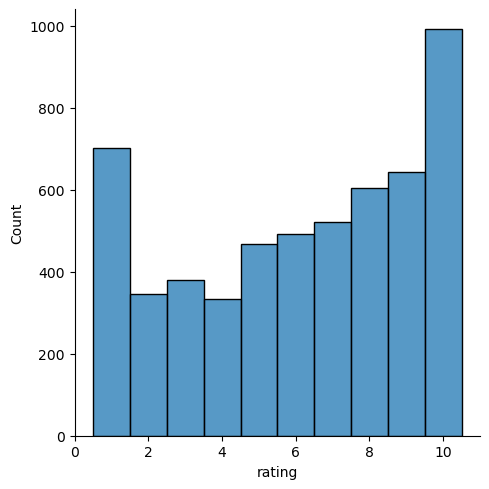

In [8]:
# distribution of rating frequency
sns.displot(df, x="rating", discrete=True)
plt.show()

In [5]:
# positive reviews vs. negative
positive = df[df["rating"] >= 7].shape[0] / df.shape[0]
negative = 1 - positive
print((positive, negative))

(0.4947991391678623, 0.5052008608321377)


From the plot above, we can see that a rating of 10/10 was the most frequent, followed by 1/10. This supports the hypothesis that *Tenet* is a "love it or hate it" movie. Reading through some of the reviews, it seemed like reviews of 7 or higher had a positive sentiment towards the movie and 6 or below had a negative sentiment. If this is the dividing line, there are about half positive reviews and half negative reviews. 

It might be interesting to see what words are frequently used for negative and positive sentiments. For this, we can use word clouds. The data was split by rating, where a rating of 10/10 are deemed positive and a rating of 1/10 are deemed negative. The code and idea for this can be attributed to this Towards Data Science <a href="https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6">article</a>.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# load data and drop NA's
df = pd.read_csv("../data/tenet_reviews.csv")
df.dropna()

# assign reviews with rating 10 as positive and 1 as negative
df = df[(df['rating'] == 10) | (df['rating'] == 1)]
df['sentiment'] = df['rating'].apply(lambda r: 1 if r == 10 else -1)
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

In [ ]:
# positive word cloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "movie", "tenet", "film", "Nolan", "Christopher", "time",
                  "one", "movies", "watch", "make", "understand"])
pos = " ".join(review for review in positive.review)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
# plt.savefig('../images/wordcloud_pos.png')

<img src="../images/wordcloud_pos.png" alt="positive-wordcloud" style="width: 400px; height: 300px; padding=0;" />

In [ ]:
# negative word cloud
neg = " ".join(review for review in negative.review)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
# plt.savefig('../images/wordcloud_neg.png')

<img src="../images/wordcloud_neg.png" alt="negative-wordcloud" style="width: 400px; height: 300px; padding=0;" />

The positive review word cloud has words like "masterpiece", "great", "love", "cinema", "amazing", "think", "music", and "enjoy". These words appeal to a sense of wonder and awe, which may be what people with positive reviews were looking for in this movie. The negative review word cloud has words like "bad", "boring", "terrible", "sound", "dialogue", "waste" and "confusing". *Tenet* did get some push back that the dialogue was difficult to hear, which is why words related to sound may have been relevant in negative reviews. 

## Summary

Overall, it appears that *Tenet* is a disbuted movie. People that enjoyed it most likey identified with the thrill and film-making of the movie, while critics found the plot confusing and audio lacking. 